In [ ]:
!pip install transformers datasets pytorch torch numpy pandas wordninja

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
from transformers import pipeline
from transformers import BertTokenizer
from collections import Counter
from spacy.tokens import Token
from spacy.matcher import Matcher
from spacy.strings import StringStore
from copy import deepcopy
import spacy
import torch
import re
import wordninja
import numpy as np
import pandas as pd
import psycopg2
import math


tokenize = spacy.load('en_core_web_sm')

In [10]:
sentiment_analyzer = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [16]:
# Connceting to DB
conn = psycopg2.connect(
    host="codd01.research.northwestern.edu",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")
cursor = conn.cursor()

In [74]:
# Querying DB for desired dataset
columns = ['crid','incident_date','cr_text','officer_id','unit_id','unit']
q1 = """SELECT da.crid as crid, da.incident_date as incident_date, da.cr_text as cr_text, doa.officer_id as officer_id, doh.unit_id as unit_id, dpu.description as unit FROM data_allegation da
LEFT JOIN data_officerallegation doa ON da.crid = doa.allegation_id
LEFT JOIN data_officerhistory doh ON doa.officer_id = doh.id
LEFT JOIN data_policeunit dpu ON doh.unit_id = dpu.id
WHERE da.is_officer_complaint IS FALSE
AND doa.allegation_id IS NOT NULL
AND da.cr_text IS NOT NULL
AND (da.incident_date > doh.effective_date AND (da.incident_date < doh.end_date) OR doh.end_date IS NULL)
AND dpu.description LIKE 'District 0%'
AND da.incident_date >= '2010-01-01'
AND da.incident_date < '2016-01-01'"""
cursor.execute(q1)
df = pd.DataFrame(data = cursor.fetchall(), columns=columns)

In [75]:
# Cleaning the text using method from Demo
def clean(text):
  if text in ['(None Entered)', 'NO AFFIDAVIT']: return ''

  text = text.replace('\n', ' ').replace('|', 'I').strip()

  text = ' '.join([word for token in text.split() for word in (wordninja.split(token) if token.isalpha() else [token])])
  return text

In [76]:
df['cleaned_text'] = df.loc[:,'cr_text'].map(clean)

In [77]:
# Extract quotes based on logic similar to Demo
df['quotes'] = df.apply(lambda row: re.findall(r'"([^"]*)"', row['cleaned_text']), axis = 1)

In [78]:
# Truncate each text column for use in sentiment analysis below
df['cleaned_text_trunc'] = df['cleaned_text'].str[:512]

In [105]:
def get_sentiment(column, key):
  return(column[0][key])

def get_score(column):
  if column[0]['label'] == 'NEGATIVE':
    return(column[0]['score'] * -1)
  else:
    return(column[0]['score'])

In [106]:
df['text_sentiment'] = df.apply(lambda row: get_sentiment(row['text_sentiment_info'],'label'), axis = 1)
df['abs_text_sentiment_score'] = df.apply(lambda row: get_sentiment(row['text_sentiment_info'],'score'), axis = 1)
df['text_sentiment_score'] = df.apply(lambda row: get_score(row['text_sentiment_info']), axis = 1)

In [134]:
df['cr_year'] = pd.to_datetime(df['incident_date'], utc=True).dt.year

In [151]:
text_scores = df.groupby(['unit'], as_index = False).agg({'crid':'count',
                                            'text_sentiment_score':'mean'})

In [152]:
text_scores_years = df.groupby(['unit','cr_year'], as_index = False).agg({'crid':'count',
                                                      'text_sentiment_score':'mean'})

In [138]:
df_quotes = df[df['quotes'].str.len() > 0]

In [139]:
# Adding sentiment data for text
df_quotes['quote_sentiment_info'] = df_quotes.apply(lambda row: sentiment_analyzer(row['quotes']), axis = 1)

In [140]:
df_quotes['quote_sentiment'] = df_quotes.apply(lambda row: get_sentiment(row['quote_sentiment_info'],'label'), axis = 1)
df_quotes['abs_quote_sentiment_score'] = df_quotes.apply(lambda row: get_sentiment(row['quote_sentiment_info'],'score'), axis = 1)
df_quotes['quote_sentiment_score'] = df_quotes.apply(lambda row: get_score(row['quote_sentiment_info']), axis = 1)

In [149]:
quotes_scores = df_quotes.groupby(['unit'], as_index = False).agg({'crid':'count',
                                                   'quote_sentiment_score':'mean'})

In [150]:
quotes_scores_years = df_quotes.groupby(['unit','cr_year'], as_index = False).agg({'crid':'count',
                                                             'quote_sentiment_score':'mean'})

In [143]:
## tie out to gender and racial entropy

In [144]:
columns = ['year','unit_id','description','officer_count','unit_males','unit_females','unit_gender_entropy']
q1 = """SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
        as unit_gender_entropy
FROM
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2011
AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2011
AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'M'
GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
LEFT JOIN (
SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2011
AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'F'
GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id
UNION ALL
SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
        as unit_gender_entropy
FROM
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2012
AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2012
AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'M'
GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
LEFT JOIN (
SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2012
AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'F'
GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id
UNION ALL
SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
        as unit_gender_entropy
FROM
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2013
AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2013
AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'M'
GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
LEFT JOIN (
SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2013
AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'F'
GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id
UNION ALL
SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
           as unit_gender_entropy
FROM
    (SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
        LEFT JOIN
    (SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.gender = 'M'
     GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
        LEFT JOIN (
        SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
        FROM data_policeunit dpu
                 LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
                 LEFT JOIN data_officer d ON doh.officer_id = d.id
        WHERE date_part('year', doh.effective_date) < 2010
          AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
          AND dpu.description LIKE '%District 0%'
          AND dpu.active = true
          AND d.gender = 'F'
        GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id
UNION ALL
SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
        as unit_gender_entropy
FROM
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2014
AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2014
AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'M'
GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
LEFT JOIN (
SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2014
AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'F'
GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id
UNION ALL
SELECT q1.*, m.unit_males, f.unit_females,
       -((m.unit_males::float/q1.officer_count::float))*log(m.unit_males::float/q1.officer_count::float)-
       ((f.unit_females::float/q1.officer_count::float))*log(f.unit_females::float/q1.officer_count::float)
        as unit_gender_entropy
FROM
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2015
AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_males
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2015
AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'M'
GROUP BY year, dpu.id, dpu.description) m ON q1.year = m.year AND q1.unit_id = m.unit_id
LEFT JOIN (
SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(d.id) as unit_females
FROM data_policeunit dpu
LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
LEFT JOIN data_officer d ON doh.officer_id = d.id
WHERE date_part('year', doh.effective_date) < 2015
AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
AND dpu.description LIKE '%District 0%'
AND dpu.active = true
AND d.gender = 'F'
GROUP BY year, dpu.id, dpu.description) f ON m.year = f.year AND m.unit_id = f.unit_id"""
cursor.execute(q1)
gender_entropy = pd.DataFrame(data = cursor.fetchall(), columns=columns)

In [146]:
columns = ['year','unit_id','description','officer_count','white_count','black_count','asian_pacific_count','native_count','hispanic_count','race_entropy']
q1 = """SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2010 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2010
       AND (date_part('year', doh.end_date) > 2010 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id

UNION ALL

SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2011 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2011
       AND (date_part('year', doh.end_date) > 2011 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id

UNION ALL

SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2012 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2012
       AND (date_part('year', doh.end_date) > 2012 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id

UNION ALL

SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2013 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2013
       AND (date_part('year', doh.end_date) > 2013 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id

UNION ALL

SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2014 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2014
       AND (date_part('year', doh.end_date) > 2014 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id

UNION ALL

SELECT q1.*, w.white_count, b.black_count, ap.asian_pacific_count, na.native_count, h.hispanic_count,
       COALESCE(-1*(((w.white_count::float/q1.officer_count::float))*log(w.white_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((b.black_count::float/q1.officer_count::float))*log(b.black_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((h.hispanic_count::float/q1.officer_count::float))*log(h.hispanic_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((ap.asian_pacific_count::float/q1.officer_count::float))*log(ap.asian_pacific_count::float/q1.officer_count::float)),0) +
       COALESCE(-1*(((na.native_count::float/q1.officer_count::float))*log(na.native_count::float/q1.officer_count::float)),0)

        as race_entropy
FROM
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as officer_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
     GROUP BY year, dpu.id, dpu.description) q1
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as white_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'White'
     GROUP BY year, dpu.id, dpu.description) w ON q1.year = w.year AND q1.unit_id = w.unit_id
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as black_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Black'
     GROUP BY year, dpu.id, dpu.description) b ON q1.year = b.year AND q1.unit_id = b.unit_id
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as asian_pacific_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Asian/Pacific'
     GROUP BY year, dpu.id, dpu.description) ap ON q1.year = ap.year AND q1.unit_id = ap.unit_id
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as native_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Native American/Alaskan Native'
     GROUP BY year, dpu.id, dpu.description) na ON q1.year = na.year AND q1.unit_id = na.unit_id
LEFT JOIN
(SELECT 2015 as year, dpu.id as unit_id, dpu.description, COUNT(doh.officer_id) as hispanic_count
     FROM data_policeunit dpu
              LEFT JOIN data_officerhistory doh on dpu.id = doh.unit_id
              LEFT JOIN data_officer d ON doh.officer_id = d.id
     WHERE date_part('year', doh.effective_date) < 2015
       AND (date_part('year', doh.end_date) > 2015 OR doh.end_date IS NULL)
       AND dpu.description LIKE '%District 0%'
       AND dpu.active = true
       AND d.race = 'Hispanic'
     GROUP BY year, dpu.id, dpu.description) h ON q1.year = h.year AND q1.unit_id = h.unit_id"""
cursor.execute(q1)
racial_entropy = pd.DataFrame(data = cursor.fetchall(), columns=columns)

In [175]:
cr_text_gender = text_scores_years.merge(gender_entropy, how = 'left', left_on = ['unit','cr_year'], right_on = ['description','year'])
cr_text_race = text_scores_years.merge(racial_entropy, how = 'left', left_on = ['unit','cr_year'], right_on = ['description','year'])

quote_text_gender = quotes_scores_years.merge(gender_entropy, how = 'left', left_on = ['unit','cr_year'], right_on = ['description','year'])
quote_text_race = quotes_scores_years.merge(racial_entropy, how = 'left', left_on = ['unit','cr_year'], right_on = ['description','year'])

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Unit Gender Entropy vs. CR Text Sentiment (Confidence Intervals)')

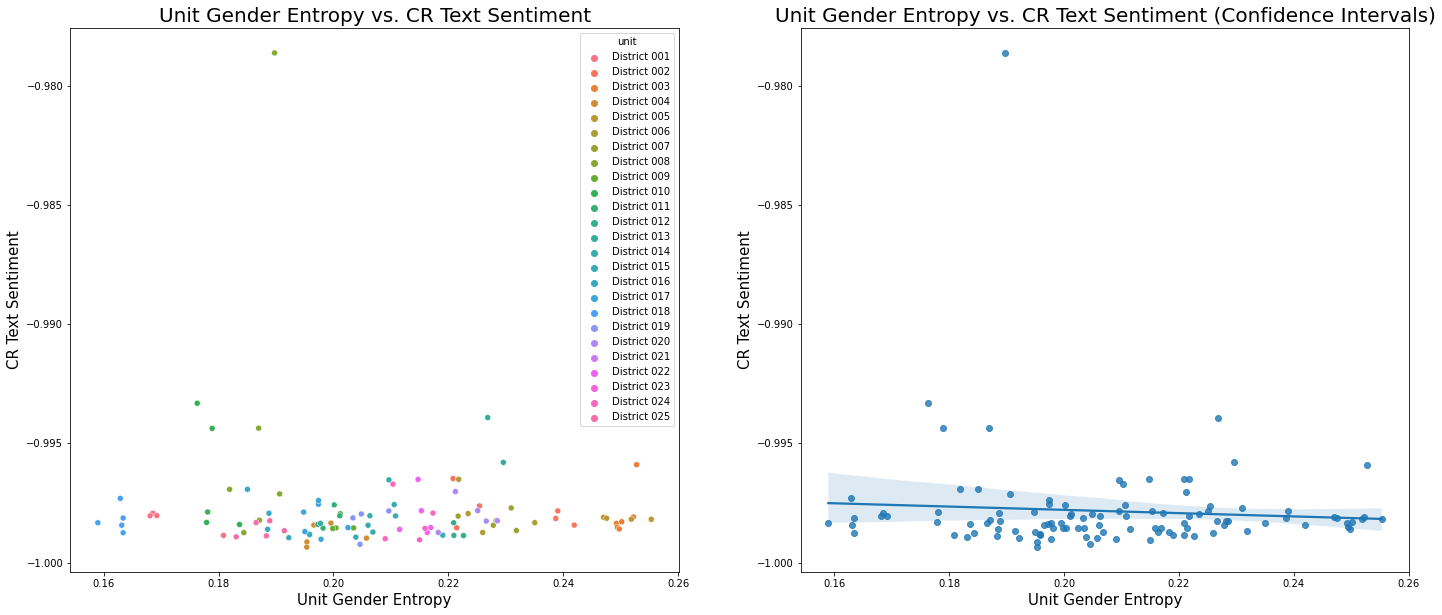

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = cr_text_gender, x = 'unit_gender_entropy', y = 'text_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Gender Entropy', size = 15)
ax1.set_ylabel('CR Text Sentiment', size = 15)
ax1.set_title('Unit Gender Entropy vs. CR Text Sentiment', size = 20)
sns.regplot(data = cr_text_gender, x = 'unit_gender_entropy', y = 'text_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Gender Entropy', size = 15)
ax2.set_ylabel('CR Text Sentiment', size = 15)
ax2.set_title('Unit Gender Entropy vs. CR Text Sentiment (Confidence Intervals)', size = 20)

Text(0.5, 1.0, 'Unit Gender Entropy vs. CR Text Sentiment (Confidence Intervals) - Outliers Removed')

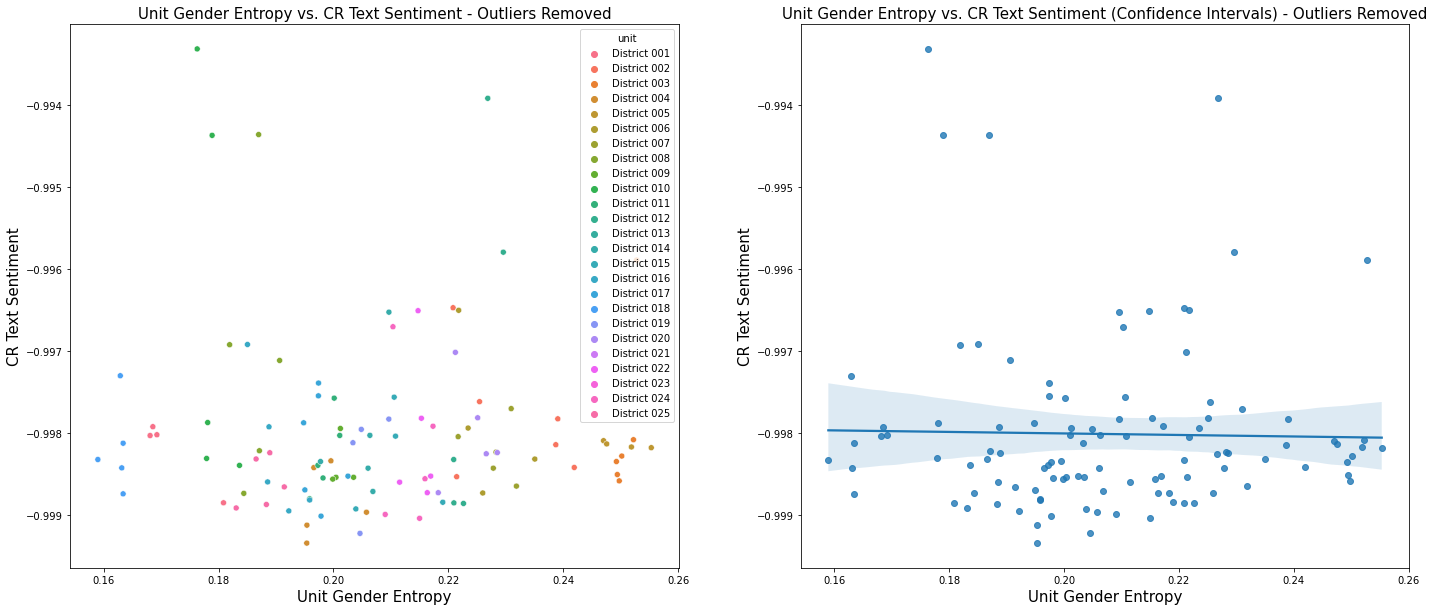

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = cr_text_gender[cr_text_gender['text_sentiment_score'] < -0.98], x = 'unit_gender_entropy', y = 'text_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Gender Entropy', size = 15)
ax1.set_ylabel('CR Text Sentiment', size = 15)
ax1.set_title('Unit Gender Entropy vs. CR Text Sentiment - Outliers Removed', size = 15)
sns.regplot(data = cr_text_gender[cr_text_gender['text_sentiment_score'] < -0.98], x = 'unit_gender_entropy', y = 'text_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Gender Entropy', size = 15)
ax2.set_ylabel('CR Text Sentiment', size = 15)
ax2.set_title('Unit Gender Entropy vs. CR Text Sentiment (Confidence Intervals) - Outliers Removed', size = 15)

Text(0.5, 1.0, 'Unit Race Entropy vs. CR Text Sentiment (Confidence Intervals)')

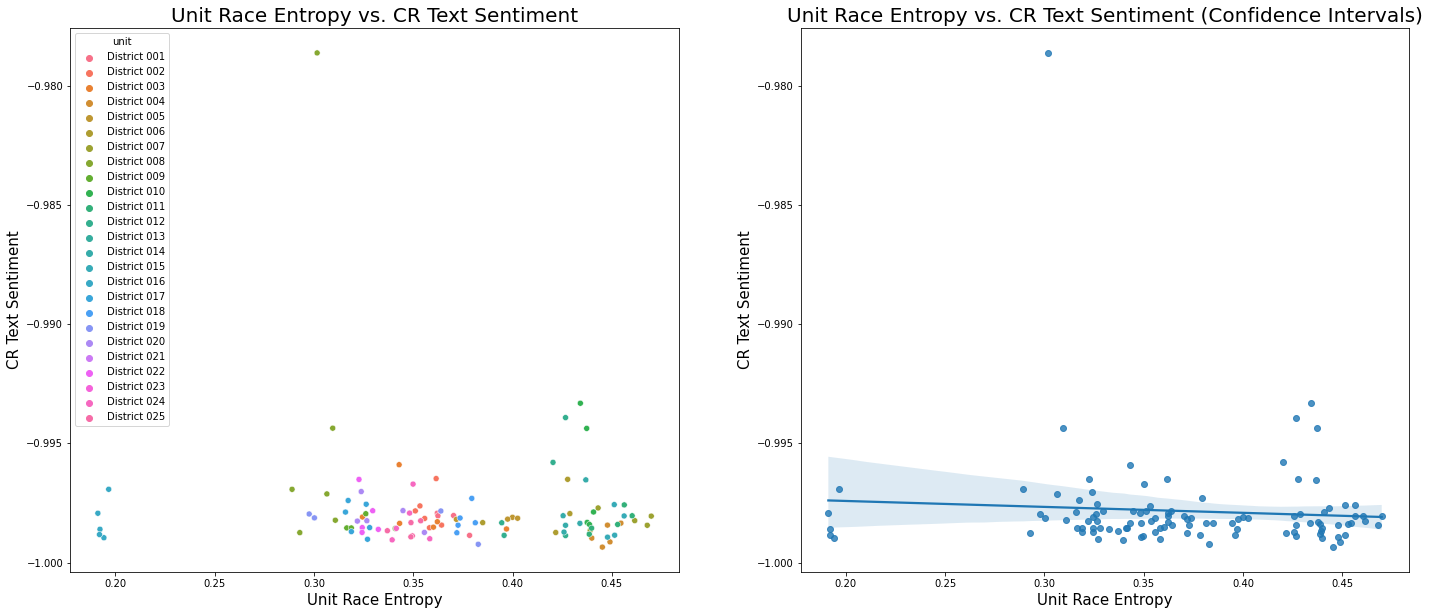

In [202]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = cr_text_race, x = 'race_entropy', y = 'text_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Race Entropy', size = 15)
ax1.set_ylabel('CR Text Sentiment', size = 15)
ax1.set_title('Unit Race Entropy vs. CR Text Sentiment', size = 20)
sns.regplot(data = cr_text_race, x = 'race_entropy', y = 'text_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Race Entropy', size = 15)
ax2.set_ylabel('CR Text Sentiment', size = 15)
ax2.set_title('Unit Race Entropy vs. CR Text Sentiment (Confidence Intervals)', size = 20)

Text(0.5, 1.0, 'Unit Race Entropy vs. CR Text Sentiment (Confidence Intervals) - Outliers Removed')

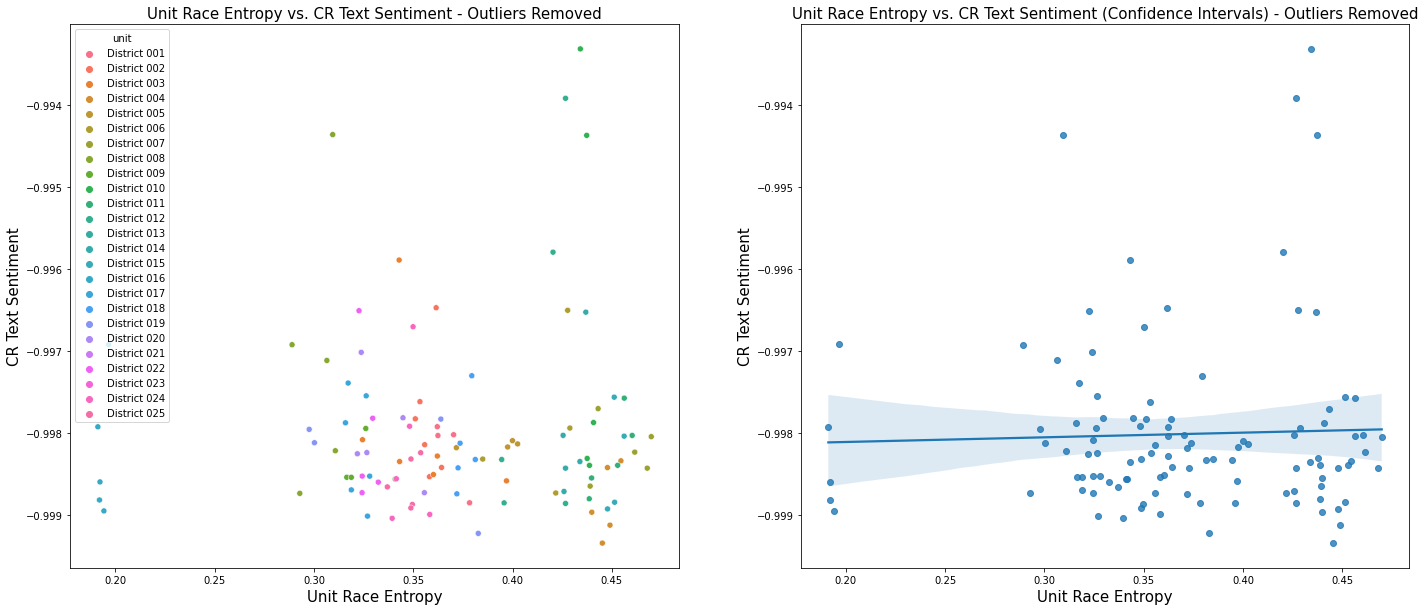

In [203]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = cr_text_race[cr_text_race['text_sentiment_score'] < -0.98], x = 'race_entropy', y = 'text_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Race Entropy', size = 15)
ax1.set_ylabel('CR Text Sentiment', size = 15)
ax1.set_title('Unit Race Entropy vs. CR Text Sentiment - Outliers Removed', size = 15)
sns.regplot(data = cr_text_race[cr_text_race['text_sentiment_score'] < -0.98], x = 'race_entropy', y = 'text_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Race Entropy', size = 15)
ax2.set_ylabel('CR Text Sentiment', size = 15)
ax2.set_title('Unit Race Entropy vs. CR Text Sentiment (Confidence Intervals) - Outliers Removed', size = 15)

Text(0.5, 1.0, 'Unit Gender Entropy vs. CR Quote Sentiment (Confidence Intervals)')

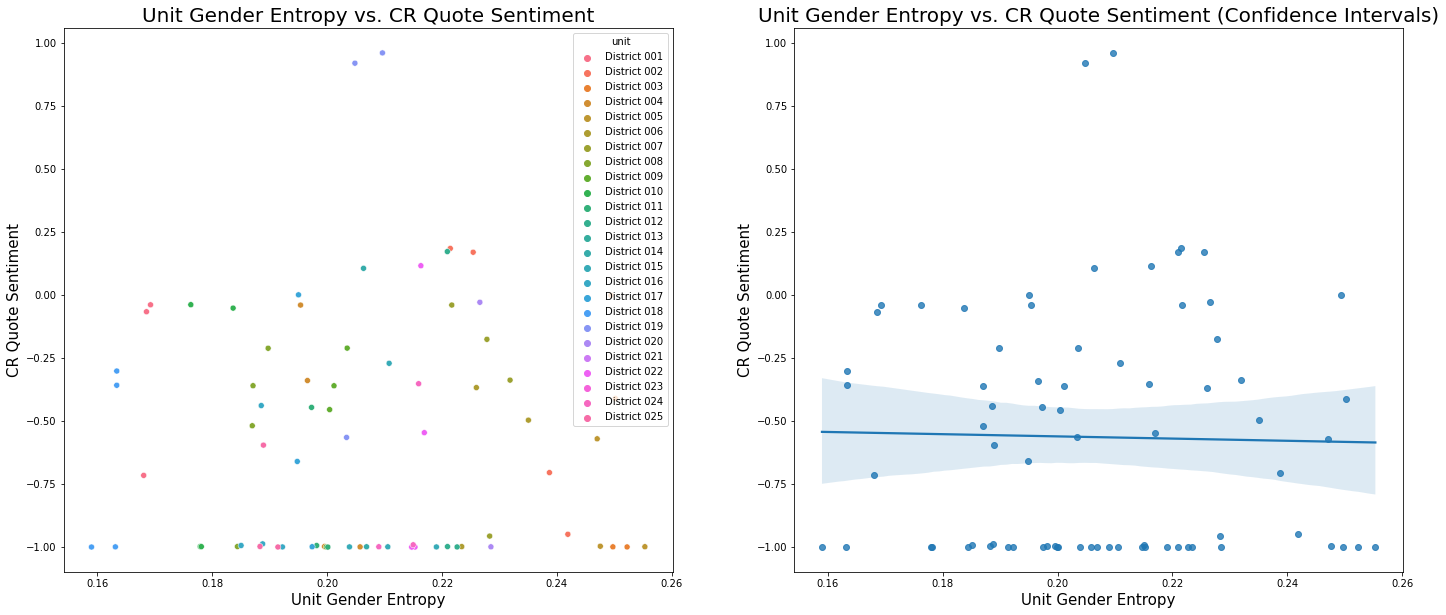

In [197]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = quote_text_gender, x = 'unit_gender_entropy', y = 'quote_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Gender Entropy', size = 15)
ax1.set_ylabel('CR Quote Sentiment', size = 15)
ax1.set_title('Unit Gender Entropy vs. CR Quote Sentiment', size = 20)
sns.regplot(data = quote_text_gender, x = 'unit_gender_entropy', y = 'quote_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Gender Entropy', size = 15)
ax2.set_ylabel('CR Quote Sentiment', size = 15)
ax2.set_title('Unit Gender Entropy vs. CR Quote Sentiment (Confidence Intervals)', size = 20)

Text(0.5, 1.0, 'Unit Race Entropy vs. CR Quote Sentiment (Confidence Intervals)')

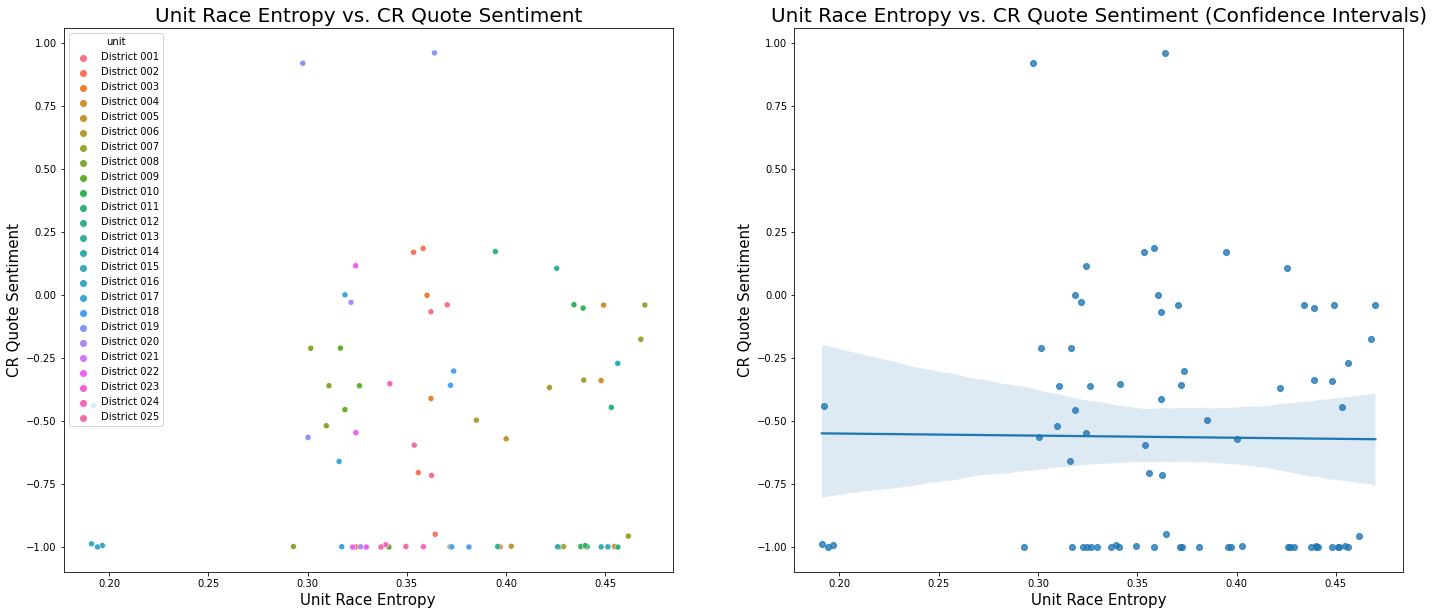

In [198]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,10))
sns.scatterplot(data = quote_text_race, x = 'race_entropy', y = 'quote_sentiment_score', hue = 'unit', ax = ax1)
ax1.set_xlabel('Unit Race Entropy', size = 15)
ax1.set_ylabel('CR Quote Sentiment', size = 15)
ax1.set_title('Unit Race Entropy vs. CR Quote Sentiment', size = 20)
sns.regplot(data = quote_text_race, x = 'race_entropy', y = 'quote_sentiment_score', ax = ax2)
ax2.set_xlabel('Unit Race Entropy', size = 15)
ax2.set_ylabel('CR Quote Sentiment', size = 15)
ax2.set_title('Unit Race Entropy vs. CR Quote Sentiment (Confidence Intervals)', size = 20)